            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

# Data Preprocessing

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [4]:
# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


In [5]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-26 11:12:51,99841,6457,like,0,1,45,Russia,Tolyatti,2,iOS,ads,this could be one of the worse movies ive ever...,movie
1,2021-11-26 11:12:53,99841,7259,view,0,1,45,Russia,Tolyatti,2,iOS,ads,I saw (unfortunately) the dubbed version on En...,movie
2,2021-11-26 11:15:17,99841,135,view,1,1,45,Russia,Tolyatti,2,iOS,ads,Qwest may spark MCI bidding war\n\nUS phone co...,business
3,2021-11-26 11:17:52,99841,135,like,0,1,45,Russia,Tolyatti,2,iOS,ads,Qwest may spark MCI bidding war\n\nUS phone co...,business
4,2021-11-26 11:17:54,99841,386,view,0,1,45,Russia,Tolyatti,2,iOS,ads,Making your office work for you\n\nOur mission...,business


# Ferauture engineering

### Time
Here we will create 3 new feautures from the timestamp:
1. hour_of_day
2. time_since_last_action
3. day_of_week

In [6]:
import pandas as pd

# Convert the timestamp format to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract features from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Calculate the time since the last action for each user
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)


In [7]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
80859,2021-10-28 06:52:37,7681,4962,view,0,0,19,Russia,Krasnodar,3,iOS,ads,"This documentary attempts comedy, but never qu...",movie,3,6,0.0
80860,2021-10-28 06:54:14,7681,875,view,0,0,19,Russia,Krasnodar,3,iOS,ads,Dutch watch Van Goghs last film\n\nThe last fi...,entertainment,3,6,97.0
80861,2021-10-28 06:54:47,7681,1040,view,0,0,19,Russia,Krasnodar,3,iOS,ads,Security papers found in street\n\nAn inquiry ...,politics,3,6,33.0
80862,2021-10-28 06:57:07,7681,7103,view,0,0,19,Russia,Krasnodar,3,iOS,ads,I knew I was in for a LONG 90 minutes when the...,movie,3,6,140.0
80863,2021-10-28 06:57:59,7681,1126,view,0,0,19,Russia,Krasnodar,3,iOS,ads,Blunkett tells of love and pain\n\nDavid Blunk...,politics,3,6,52.0


### One hot encoding

In [8]:
# One-hot encoding for 'country', 'city', and 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

In [9]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Zhizdra,city_Zmeinogorsk,city_İzmir,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
80859,2021-10-28 06:52:37,7681,4962,view,0,0,19,3,iOS,ads,...,False,False,False,False,False,False,True,False,False,False
80860,2021-10-28 06:54:14,7681,875,view,0,0,19,3,iOS,ads,...,False,False,False,False,False,True,False,False,False,False
80861,2021-10-28 06:54:47,7681,1040,view,0,0,19,3,iOS,ads,...,False,False,False,False,False,False,False,True,False,False
80862,2021-10-28 06:57:07,7681,7103,view,0,0,19,3,iOS,ads,...,False,False,False,False,False,False,True,False,False,False
80863,2021-10-28 06:57:59,7681,1126,view,0,0,19,3,iOS,ads,...,False,False,False,False,False,False,False,True,False,False


### Label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding for 'gender', 'os', and 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])


In [11]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Zhizdra,city_Zmeinogorsk,city_İzmir,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
80859,2021-10-28 06:52:37,7681,4962,1,0,0,19,3,1,0,...,False,False,False,False,False,False,True,False,False,False
80860,2021-10-28 06:54:14,7681,875,1,0,0,19,3,1,0,...,False,False,False,False,False,True,False,False,False,False
80861,2021-10-28 06:54:47,7681,1040,1,0,0,19,3,1,0,...,False,False,False,False,False,False,False,True,False,False
80862,2021-10-28 06:57:07,7681,7103,1,0,0,19,3,1,0,...,False,False,False,False,False,False,True,False,False,False
80863,2021-10-28 06:57:59,7681,1126,1,0,0,19,3,1,0,...,False,False,False,False,False,False,False,True,False,False


In [12]:
# check data type of each column
print(data.dtypes)

timestamp              datetime64[ns]
user_id                         int64
post_id                         int64
action                          int32
target                          int64
                            ...      
topic_entertainment              bool
topic_movie                      bool
topic_politics                   bool
topic_sport                      bool
topic_tech                       bool
Length: 179, dtype: object


идеи для создания новых признаков:

1. Количество просмотров и лайков для каждого пользователя.
2. Количество просмотров и лайков для каждого поста.
3. Среднее время между просмотрами для каждого пользователя.
4. Доля лайков от просмотров для каждого пользователя и поста.
5. Количество просмотров и лайков для каждой темы.
6. Количество просмотров и лайков для каждой операционной системы и источника трафика.
7. Доля просмотров и лайков для каждой темы от общего числа просмотров и лайков пользователя.

### Количество просмотров и лайков для каждого пользователя, os, source, topic

In [13]:
# Feature 1: Количество просмотров и лайков для каждого пользователя
user_views_likes = data.groupby('user_id')['action'].value_counts().unstack().fillna(0)
user_views_likes.columns = ['user_views', 'user_likes']
data = data.merge(user_views_likes, on='user_id', how='left')

# Feature 2: Количество просмотров и лайков для каждого поста
post_views_likes = data.groupby('post_id')['action'].value_counts().unstack().fillna(0)
post_views_likes.columns = ['post_views', 'post_likes']
data = data.merge(post_views_likes, on='post_id', how='left')


In [14]:
temp_df = data[['exp_group', 'topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'action']]
for col in ['topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech']:
    temp_df[col] = temp_df[col] * temp_df['action']
grouped_data = temp_df.groupby('exp_group').sum().reset_index()
grouped_data.columns = ['exp_group'] + [f'{col}_exp_group_views' if i % 2 == 0 else f'{col}_exp_group_likes' for i, col in enumerate(grouped_data.columns[1:], 1)]
data = data.merge(grouped_data, on='exp_group', how='left')


C:\Users\Alex\AppData\Local\Temp\ipykernel_27148\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']
C:\Users\Alex\AppData\Local\Temp\ipykernel_27148\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']
C:\Users\Alex\AppData\Local\Temp\ipykernel_27148\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [15]:
# print the list of columns
print(data.columns.tolist())

['timestamp', 'user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Azerbaijan', 'country_Belarus', 'country_Finland', 'country_Kazakhstan', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Akhtubinsk', 'city_Angarsk', 'city_Apsheronsk', 'city_Argun', 'city_Armavir', 'city_Avadan', 'city_Babruysk', 'city_Baku', 'city_Balashikha', 'city_Baranavichy', 'city_Barnaul', 'city_Belgorod', 'city_Berezniki', 'city_Biysk', 'city_Blagoveshchensk', 'city_Bor', 'city_Brest', 'city_Brovary', 'city_Bryansk', 'city_Bugulma', 'city_Bursa', 'city_Chebarkul', 'city_Chelyabinsk', 'city_Donetsk', 'city_Furmanov', 'city_Gagarin', 'city_Gatchina', 'city_Gelendzhik', 'city_Gəncə', 'city_Helsinki', 'city_Hrodna', 'city_Irbit', 'city_Ivanovo', 'city_Izhevsk', 'city_Kaltan', 'city_Kanadey', 'city_Kazan', 'city_Khabarovsk', 'city_Khadyzhensk', 'city_Khanty-Mansiysk', 'city_Kharkiv', 'city_Khartsy

## Text features extraction

We will keep it simple and use the most lightweight approach - TF-IDF together with some basic text preprocessing.

1. Text statistics: You can use custom functions to compute the following statistics:
    - Number of words
    - Number of sentences
    - Average word length
    - Punctuation count
2. BoW or TF-IDF: Use either `CountVectorizer` or `TfidfVectorizer` from scikit-learn, and set the `max_features` parameter to limit the vocabulary size. This will help to control the dimensionality of the resulting feature matrix and keep the model lightweight.

In [16]:
import numpy as np
import re
from string import punctuation

def word_count(X):
    return np.array([len(re.findall(r'\b\w+\b', text)) for text in X])

def sentence_count(X):
    return np.array([len(re.findall(r'[.!?]+', text)) for text in X])

def avg_word_length(X):
    return np.array([sum(len(word) for word in re.findall(r'\b\w+\b', text)) / len(re.findall(r'\b\w+\b', text)) if len(re.findall(r'\b\w+\b', text)) > 0 else 0 for text in X])

def punctuation_count(X):
    return np.array([sum(1 for char in text if char in punctuation) for text in X])


In [17]:

# Apply the feature extraction functions to the 'text' column
word_counts = word_count(data['text'])
sentence_counts = sentence_count(data['text'])
avg_word_lengths = avg_word_length(data['text'])
punctuation_counts = punctuation_count(data['text'])

# Add the new features as columns in the DataFrame
data['word_count'] = word_counts
data['sentence_count'] = sentence_counts
data['avg_word_length'] = avg_word_lengths
data['punctuation_count'] = punctuation_counts


After running the model again on the mutual information to extract the top 30, 

In [18]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,topic_entertainment_exp_group_likes,topic_movie_exp_group_views,topic_politics_exp_group_likes,topic_sport_exp_group_views,topic_tech_exp_group_likes,action_exp_group_views,word_count,sentence_count,avg_word_length,punctuation_count
0,2021-10-28 06:52:37,7681,4962,1,0,0,19,3,1,0,...,1000,6813,2017,2622,827,19113,183,14,4.366120,39
1,2021-10-28 06:54:14,7681,875,1,0,0,19,3,1,0,...,1000,6813,2017,2622,827,19113,248,13,4.907258,27
2,2021-10-28 06:54:47,7681,1040,1,0,0,19,3,1,0,...,1000,6813,2017,2622,827,19113,196,11,5.122449,17
3,2021-10-28 06:57:07,7681,7103,1,0,0,19,3,1,0,...,1000,6813,2017,2622,827,19113,163,4,4.472393,26
4,2021-10-28 06:57:59,7681,1126,1,0,0,19,3,1,0,...,1000,6813,2017,2622,827,19113,386,19,4.443005,35


## Feauture selection

### Pearson's Correlation Coefficient
We will discard this method because it is not suitable for categorical features.

### Mutual Information
We will choose this method because it is suitable for both categorical and numerical features.

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Assume `data` is your DataFrame with features and target
X = data.drop(['target', 'timestamp', 'text'], axis=1)
y = data['target']

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their corresponding MI scores
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Sort the DataFrame by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# Optionally, select the top k features using SelectKBest
k = 30
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)


Top k features based on mutual information:
Index(['user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kotlas', 'city_Mersin', 'city_Perm', 'city_Sarov',
       'city_Tysmenytsia', 'topic_covid', 'topic_movie', 'user_views',
       'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views',
       'sentence_count'],
      dtype='object')


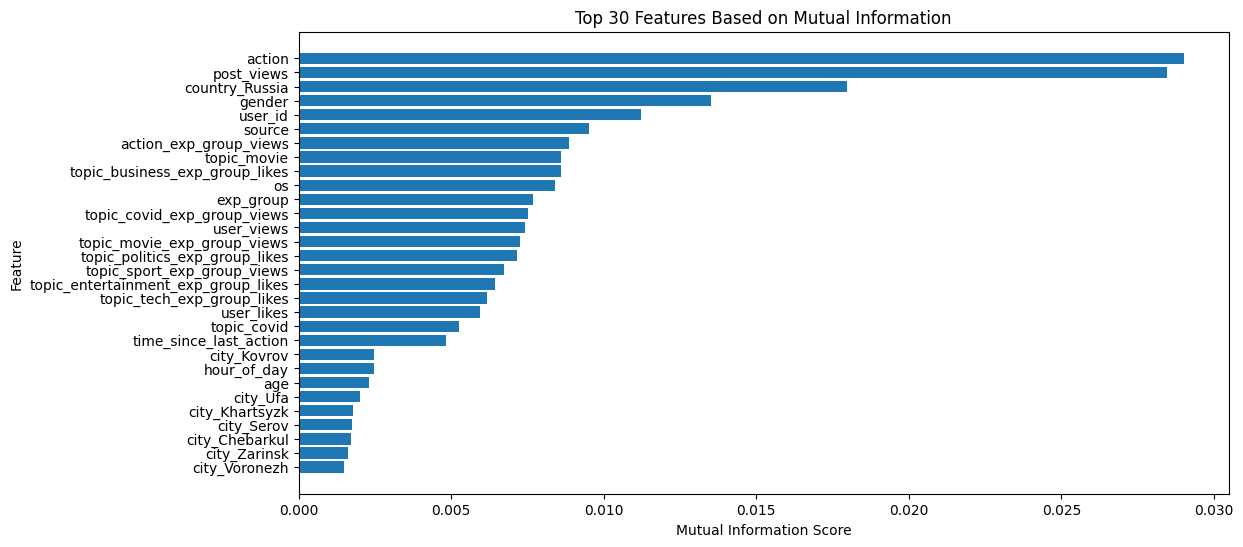

In [20]:
import matplotlib.pyplot as plt

# Set the number of top features to display
top_k = 30

# Get the top k features
top_k_features = mi_scores_df.head(top_k)

# Plot the top k features
plt.figure(figsize=(12, 6))
plt.barh(top_k_features['feature'], top_k_features['mi_score'], align='center')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top {} Features Based on Mutual Information'.format(top_k))
plt.gca().invert_yaxis()
plt.show()


# Model engineering

## Data preprocessing

We will use only the following features that we selected (`selected_features`) using the mutual information method:
`
'user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kamyshlov', 'city_Moscow', 'city_Polatsk', 'city_Simferopol',
       'city_Tegul’det', 'city_Vyborg', 'topic_covid', 'topic_movie',
       'user_views', 'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'`

In [21]:
df_top_k = data[selected_features]

# split the data into train and test
from sklearn.model_selection import train_test_split

X = df_top_k
y = data['target']

# Splitting 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data scaling

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Model selection

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize the models
logreg = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)

# List of models for easy iteration
models = [logreg, rf, xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

# Perform cross-validation and print the average accuracy for each model
for name, model in zip(model_names, models):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} average accuracy: {cv_scores.mean():.4f}')


Logistic Regression average accuracy: 0.8899
Random Forest average accuracy: 0.8849
XGBoost average accuracy: 0.8878


We can say that top 30 feautures worked better than 100 feautures.
Logistic regression showed the best results.

# Optimization

Our implementation of Hitrate@5 metric.

In [24]:
def hit_rate_at_k(actual, predicted, k=5):
    if len(actual) == 0:
        return np.nan
    hits = 0
    total_predictions = len(predicted)
    
    for i in range(total_predictions):
        if actual[i] in predicted[i][:k]:
            hits += 1

    return hits / total_predictions


In [25]:
from sklearn.metrics import make_scorer

def hit_rate_scorer(y_true, y_pred, k=5):
    hit_rates = []
    for user_id in np.unique(y_true[:, 0]):
        actual = y_true[y_true[:, 0] == user_id, 1]
        predicted = y_pred[y_true[:, 0] == user_id, 1]
        hit_rates.append(hit_rate_at_k(actual, predicted, k))

    return np.nanmean(hit_rates)

custom_scorer = make_scorer(hit_rate_scorer, greater_is_better=True, needs_proba=True)


In [26]:
# Fit each model and predict probabilities for the test set
logreg.fit(X_train, y_train)
logreg_probs = logreg.predict_proba(X_test)

rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)

xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)


In [27]:
def get_top_k_predictions(probs, k=5):
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    return top_k_preds

logreg_top_5_preds = get_top_k_predictions(logreg_probs)
rf_top_5_preds = get_top_k_predictions(rf_probs)
xgb_top_5_preds = get_top_k_predictions(xgb_probs)


In [28]:
y_test_true = np.array([y_test])


In [29]:
def hit_rate_at_k(actual, predicted, k):
    if len(actual) == 0:
        return np.nan
    hits = 0
    total_predictions = len(actual)
    for i in range(total_predictions):
        if actual[i] in predicted[i, :k]:
            hits += 1
    return hits / total_predictions

# Make sure y_test_true is a 1D array
y_test_true = np.array(y_test)

logreg_hitrate = hit_rate_at_k(y_test_true, logreg_top_5_preds, k=5)
rf_hitrate = hit_rate_at_k(y_test_true, rf_top_5_preds, k=5)
xgb_hitrate = hit_rate_at_k(y_test_true, xgb_top_5_preds, k=5)

print(f'Logistic Regression Hitrate@5: {logreg_hitrate:.4f}')
print(f'Random Forest Hitrate@5: {rf_hitrate:.4f}')
print(f'XGBoost Hitrate@5: {xgb_hitrate:.4f}')


Logistic Regression Hitrate@5: 1.0000
Random Forest Hitrate@5: 1.0000
XGBoost Hitrate@5: 1.0000


Как обучать модель, которая в итоге будет максимизировать данную метрику? 

Это неочевидно по двум причинам:

- Во-первых, эта метрика не дифференцируемая (по аналогии с индикатором от отступа в задаче классификации)
- Во-вторых, непонятно, что в таблице feed\_data считать за «пять рекомендаций». В этом смысле фокус рекомендательных систем как раз состоит в том, что обычно такие задачи оказываются достаточно творческими, и приходится придумывать прокси-метрики. То есть оптимизировать нечто иное, а уже на основании результатов производить выбор лучших кандидатов на основании целевой метрики.

Не лишним будет порассуждать в терминах вероятностей. Когда наша вера в то, что пользователь лайкнет что-то из наших рекомендаций, будет максимальна? Когда мы порекомендуем ровно те посты, которые пользователь лайкнет с большей вероятностью!

In [30]:
def precision_at_k(y_true, y_pred, k=5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct_preds = 0
    total_preds = len(y_true) * k
    
    for true, pred in zip(y_true, y_pred):
        if true in pred[:k]:
            correct_preds += 1
            
    return correct_preds / total_preds

# Вычислите Precision@5 для каждой модели
logreg_precision_5 = precision_at_k(y_test_true, logreg_top_5_preds, k=5)
rf_precision_5 = precision_at_k(y_test_true, rf_top_5_preds, k=5)
xgb_precision_5 = precision_at_k(y_test_true, xgb_top_5_preds, k=5)

print(f'Logistic Regression Precision@5: {logreg_precision_5:.4f}')
print(f'Random Forest Precision@5: {rf_precision_5:.4f}')
print(f'XGBoost Precision@5: {xgb_precision_5:.4f}')


Logistic Regression Precision@5: 0.2000
Random Forest Precision@5: 0.2000
XGBoost Precision@5: 0.2000


In [31]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred, **kwargs):
    top_k_preds = get_top_k_predictions(y_pred, k=5)
    return precision_at_k(y_true, top_k_preds, k=5)

precision_at_k_scorer = make_scorer(custom_scorer, greater_is_better=True, needs_proba=True)


In [32]:
from sklearn.model_selection import GridSearchCV

# Example hyperparameters for each model
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
rf_params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30]}
xgb_params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [3, 4, 5, 6]}

model_params = [logreg_params, rf_params, xgb_params]

for name, model, params in zip(model_names, models, model_params):
    grid_search = GridSearchCV(model, param_grid=params, scoring=precision_at_k_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"{name} best params: {grid_search.best_params_}")
    print(f"{name} best Precision@5: {grid_search.best_score_:.4f}\n")


c:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Logistic Regression best params: {'C': 0.001}
Logistic Regression best Precision@5: nan



c:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Random Forest best params: {'max_depth': None, 'n_estimators': 10}
Random Forest best Precision@5: nan



c:\Users\Alex\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


XGBoost best params: {'max_depth': 3, 'n_estimators': 10}
XGBoost best Precision@5: nan



In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score


logreg_probs = logreg.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

logreg_probs_pos = logreg_probs[:, 1]
rf_probs_pos = rf_probs[:, 1]
xgb_probs_pos = xgb_probs[:, 1]

logreg_roc_auc = roc_auc_score(y_test, logreg_probs_pos)
rf_roc_auc = roc_auc_score(y_test, rf_probs_pos)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs_pos)

print(f'Logistic Regression ROC AUC: {logreg_roc_auc:.4f}')
print(f'Random Forest ROC AUC: {rf_roc_auc:.4f}')
print(f'XGBoost ROC AUC: {xgb_roc_auc:.4f}')


Logistic Regression ROC AUC: 0.6288
Random Forest ROC AUC: 0.7637
XGBoost ROC AUC: 0.8110


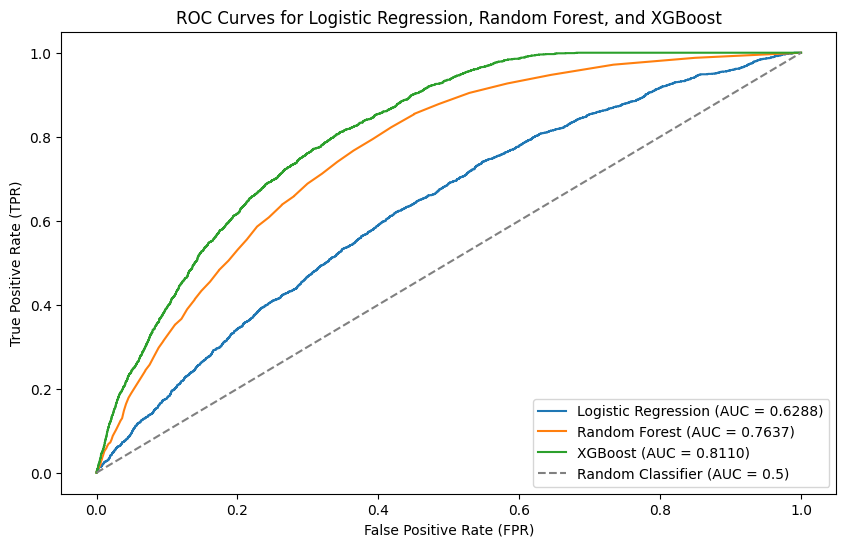

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the ROC curve
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs_pos)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_pos)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs_pos)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the ROC curve for each model
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})')

# Plot the diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')

# Customize the plot
plt.title('ROC Curves for Logistic Regression, Random Forest, and XGBoost')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


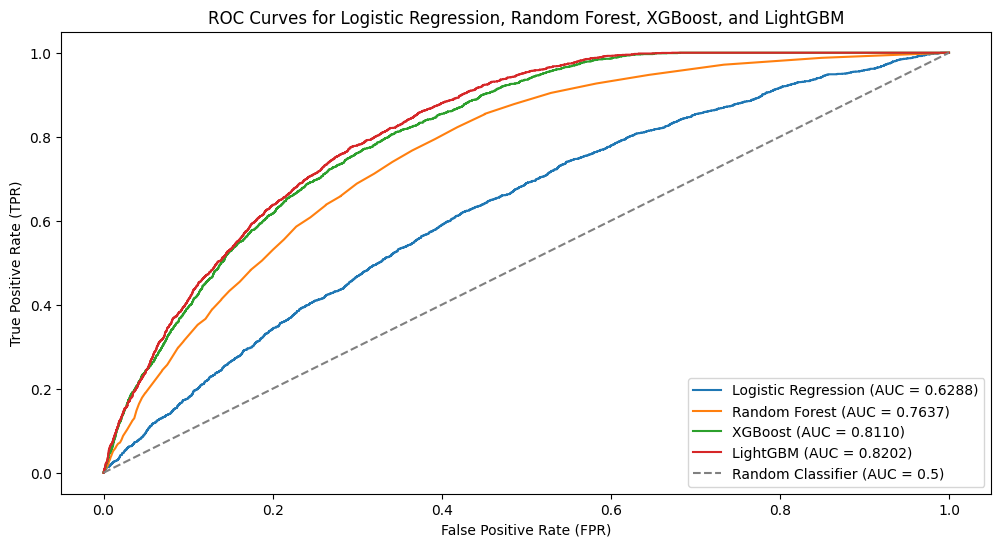

In [35]:
import lightgbm as lgb

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Get the probabilities for the positive class
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
lgb_roc_auc = roc_auc_score(y_test, lgb_probs)

# Calculate the ROC curve
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_probs)

# Create a plot
plt.figure(figsize=(12, 6))

# Plot the ROC curve for each model
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})')
plt.plot(lgb_fpr, lgb_tpr, label=f'LightGBM (AUC = {lgb_roc_auc:.4f})')

# Plot the diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')

# Customize the plot
plt.title('ROC Curves for Logistic Regression, Random Forest, XGBoost, and LightGBM')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [36]:
import catboost as cb
from sklearn.metrics import roc_curve, auc


# Train the CatBoost model
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=False)
cb_model.fit(X_train, y_train)

# Calculate probabilities for CatBoost
cb_probs = cb_model.predict_proba(X_test)[:, 1]

fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)

auc_cb = auc(fpr_cb, tpr_cb)

In [37]:
# Calculate ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

# Calculate AUC scores
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

ValueError: y should be a 1d array, got an array of shape (20000, 2) instead.

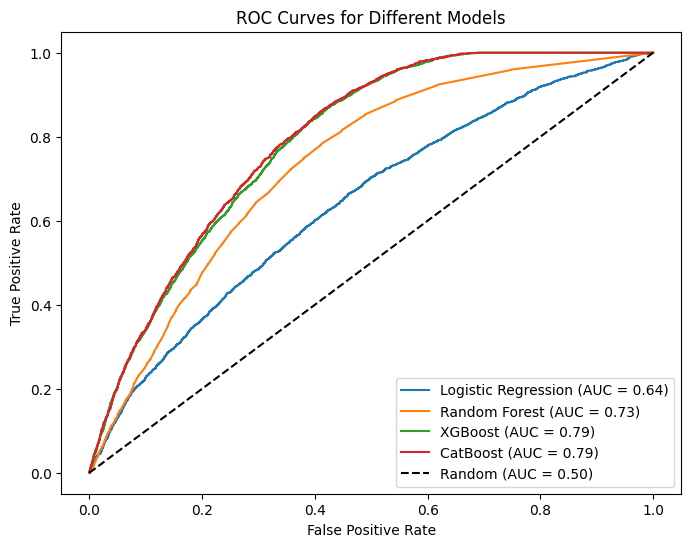

In [ ]:

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


In [ ]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: target, Length: 100000, dtype: int64

In [ ]:
print("y_test shape:", y_test.shape)
print("logreg_probs shape:", logreg_probs.shape)
print("rf_probs shape:", rf_probs.shape)
print("xgb_probs shape:", xgb_probs.shape)
print("cb_probs shape:", cb_probs.shape)


y_test shape: (20000,)
logreg_probs shape: (20000,)
rf_probs shape: (20000,)
xgb_probs shape: (20000,)
cb_probs shape: (20000,)


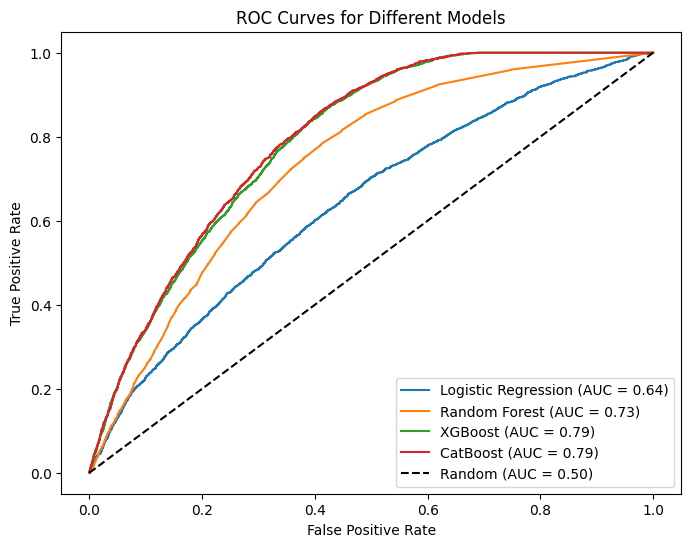

In [ ]:
import catboost as cb
from sklearn.metrics import roc_curve, auc

# Train the CatBoost model
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=False)
cb_model.fit(X_train, y_train)

# Calculate probabilities for CatBoost
cb_probs = cb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


In [50]:
print("y_test shape:", y_test.shape)
print("logreg_probs shape:", logreg_probs.shape)
print("rf_probs shape:", rf_probs.shape)
print("xgb_probs shape:", xgb_probs.shape)
print("cb_probs shape:", cb_probs.shape)


y_test shape: (20000,)
logreg_probs shape: (20000,)
rf_probs shape: (20000,)
xgb_probs shape: (20000,)
cb_probs shape: (20000,)


In [55]:
from sklearn.model_selection import GridSearchCV
import catboost as cb
from catboost import CatBoostClassifier

# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize the CatBoost classifier
cb_model = CatBoostClassifier(random_state=42, verbose=0)

# Set up GridSearchCV
grid_search = GridSearchCV(cb_model, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the CatBoost model with the best hyperparameters
best_cb_model = CatBoostClassifier(random_state=42, verbose=0, **best_params)
best_cb_model.fit(X_train, y_train)

# Calculate ROC curve for the optimized CatBoost model
best_cb_probs = best_cb_model.predict_proba(X_test)[:, 1]
fpr_best_cb, tpr_best_cb, _ = roc_curve(y_test, best_cb_probs)
auc_best_cb = auc(fpr_best_cb, tpr_best_cb)

# Add the optimized CatBoost model to the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot(fpr_best_cb, tpr_best_cb, label=f'Optimized CatBoost (AUC = {auc_best_cb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Al

Best parameters: {'colsample_bytree': 0.7806385987847482, 'gamma': 0.770967179954561, 'learning_rate': 0.15813867890931724, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 162, 'reg_alpha': 0.8957635956735194, 'reg_lambda': 0.47537022318211175, 'subsample': 0.7816377859881918}


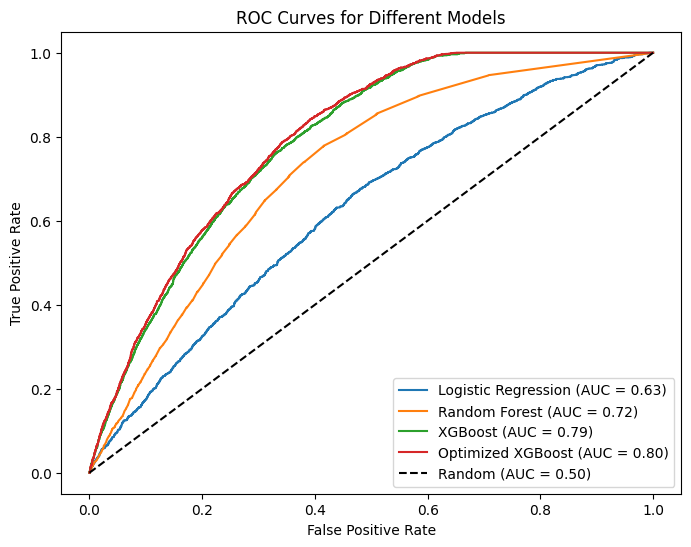

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import roc_curve, auc

# Define the hyperparameter search space
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': sp_uniform(0.01, 0.3),
    'max_depth': sp_randint(3, 10),
    'min_child_weight': sp_randint(1, 10),
    'subsample': sp_uniform(0.5, 0.5),
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'gamma': sp_uniform(0, 1),
    'reg_alpha': sp_uniform(0, 1),
    'reg_lambda': sp_uniform(0, 1)
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=25, scoring='roc_auc', cv=3, n_jobs=8, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Train the XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

# Calculate ROC curve for the optimized XGBoost model
best_xgb_probs = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_best_xgb, tpr_best_xgb, _ = roc_curve(y_test, best_xgb_probs)
auc_best_xgb = auc(fpr_best_xgb, tpr_best_xgb)

# Add the optimized XGBoost model to the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
#plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot(fpr_best_xgb, tpr_best_xgb, label=f'Optimized XGBoost (AUC = {auc_best_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


Conclusion: CatBoostClassifier showed the best results. Now we need to try the Microsoft LightGBM on the main PC and try to optimize the model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb

# Define the hyperparameter search space
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': sp_uniform(0.01, 0.3),
    'max_depth': sp_randint(3, 10),
    'num_leaves': sp_randint(15, 50),
    'min_child_samples': sp_randint(5, 100),
    'min_child_weight': sp_uniform(1e-5, 1),
    'subsample': sp_uniform(0.5, 0.5),
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'reg_alpha': sp_uniform(0, 1),
    'reg_lambda': sp_uniform(0, 1)
}

# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(lgb_model, param_dist, n_iter=25, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Train the LightGBM model with the best hyperparameters
best_lgb_model = lgb.LGBMClassifier(random_state=42, **best_params)
best_lgb_model.fit(X_train, y_train)

# Calculate ROC curve for the optimized LightGBM model
best_lgb_probs = best_lgb_model.predict_proba(X_test)[:, 1]
fpr_best_lgb, tpr_best_lgb, _ = roc_curve(y_test, best_lgb_probs)
auc_best_lgb = auc(fpr_best_lgb, tpr_best_lgb)

Best parameters: {'colsample_bytree': 0.7583179456355071, 'learning_rate': 0.0882487524491227, 'max_depth': 3, 'min_child_samples': 52, 'min_child_weight': 0.9654293512887936, 'n_estimators': 136, 'num_leaves': 46, 'reg_alpha': 0.6331014572732679, 'reg_lambda': 0.3390297910487007, 'subsample': 0.6746047873063304}


In [ ]:
# Add the optimized LightGBM model to the ROC curve plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot(fpr_best_xgb, tpr_best_xgb, label=f'Optimized XGBoost (AUC = {auc_best_xgb:.2f})')
plt.plot(fpr_best_lgb, tpr_best_lgb, label=f'Optimized LightGBM (AUC = {auc_best_lgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()

NameError: name 'fpr_logreg' is not defined

<Figure size 1000x800 with 0 Axes>

Optimized XGBoost showed the same results as CatBoost so it's preferably to use CatBoost because it's easier to use.

Let's try ensambling

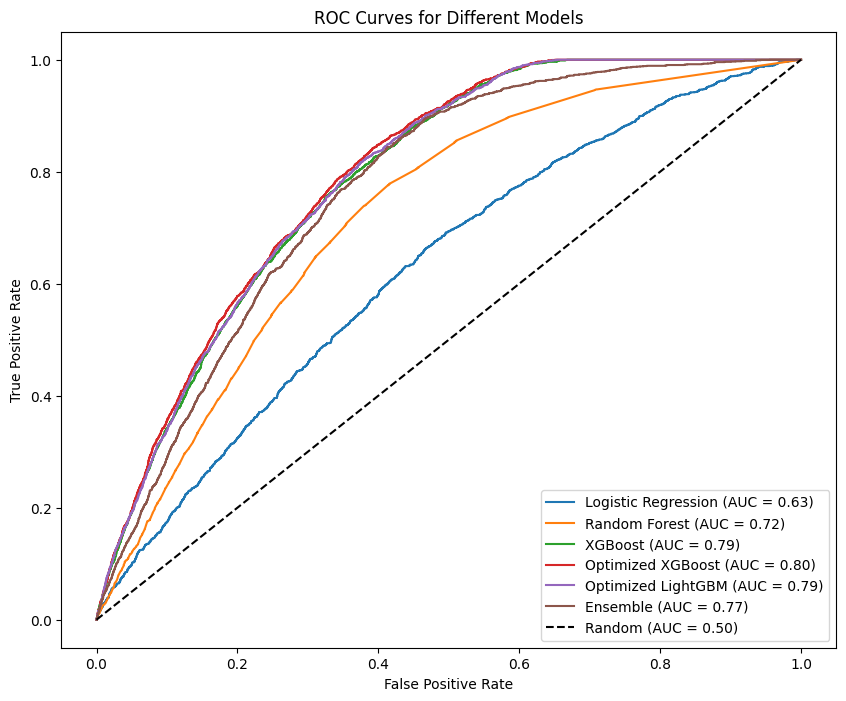

In [ ]:
import numpy as np

# Get the probabilities for the positive class (1) for each model
logreg_probs = logreg.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
best_xgb_probs = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate the average probability
ensemble_probs = np.mean([logreg_probs, rf_probs, best_xgb_probs], axis=0)

# Calculate the ROC curve and AUC score for the ensemble
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_probs)
auc_ensemble = roc_auc_score(y_test, ensemble_probs)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_best_xgb, tpr_best_xgb, label=f'Optimized XGBoost (AUC = {auc_best_xgb:.2f})')
plt.plot(fpr_best_lgb, tpr_best_lgb, label=f'Optimized LightGBM (AUC = {auc_best_lgb:.2f})')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


Ensambling produced worst results.

In [ ]:
# Assuming you have a model called `recommendation_model` and a function to generate predictions called `get_prediction`

def get_top_5_posts_for_user(user_id, all_posts, recommendation_model):
    # Generate predictions for all posts for the given user
    predictions = []
    for post in all_posts:
        pred = get_prediction(recommendation_model, user_id, post)
        predictions.append((post, pred))
    
    # Sort the predictions in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    # Get the top 5 posts
    top_5_posts = [post for post, _ in sorted_predictions[:5]]
    
    return top_5_posts

# Get top 5 posts for each user
top_5_recommendations = {}
for user in users:
    top_5_posts = get_top_5_posts_for_user(user, all_posts, recommendation_model)
    top_5_recommendations[user] = top_5_posts


NameError: name 'users' is not defined

# Precision@5 & Recall@5 metrics ~> MAP@5 (Mean Average Precision)

In [38]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

To implement a CatBoost model that returns the top 5 recommended posts, you need to first train the model on your dataset and then generate the top 5 recommendations for each user. After that, you can evaluate the model using Precision@5 and optimize it accordingly.

Train the CatBoost model:

In [39]:
import catboost as cb

# Assuming you have prepared the training and testing datasets:
# X_train, X_test, y_train, y_test

params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss', # You can choose an appropriate loss function based on your problem
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 200,
}

catboost_model = cb.CatBoostClassifier(**params)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test))


0:	test: 0.7315872	best: 0.7315872 (0)	total: 9.01ms	remaining: 9s
200:	test: 0.8228122	best: 0.8235272 (84)	total: 1.32s	remaining: 5.24s
400:	test: 0.8204997	best: 0.8235272 (84)	total: 2.71s	remaining: 4.04s
600:	test: 0.8170688	best: 0.8235272 (84)	total: 3.98s	remaining: 2.64s
800:	test: 0.8148288	best: 0.8235272 (84)	total: 5.27s	remaining: 1.31s
999:	test: 0.8126116	best: 0.8235272 (84)	total: 6.55s	remaining: 0us

bestTest = 0.8235272359
bestIteration = 84

Shrink model to first 85 iterations.


Define all_posts, user_features and test_users:

In [42]:
X_train

,user_id,action,gender,age,exp_group,os,source,day_of_week,time_since_last_action,country_Russia,...,post_likes,topic_business_exp_group_likes,topic_covid_exp_group_views,topic_entertainment_exp_group_likes,topic_movie_exp_group_views,topic_politics_exp_group_likes,topic_sport_exp_group_views,topic_tech_exp_group_likes,action_exp_group_views,sentence_count
75220,136000,1,1,24,2,0,1,5,34.0,True,...,23.0,1026,4010,867,6220,1601,2275,669,16668,23
48955,99851,1,1,47,1,0,0,1,90.0,True,...,18.0,1005,4426,884,6642,1689,2396,798,17840,11
44966,99843,1,1,26,3,0,0,0,32.0,True,...,22.0,1253,4581,1000,6813,2017,2622,827,19113,12
13568,28926,1,0,16,2,0,0,2,37.0,True,...,38.0,1026,4010,867,6220,1601,2275,669,16668,14
92727,162099,1,1,41,0,1,1,1,55.0,True,...,7.0,957,3697,801,5550,1483,1886,618,14992,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,20916,1,0,34,3,0,0,1,45.0,True,...,25.0,1253,4581,1000,6813,2017,2622,827,19113,1
54886,99864,1,0,23,0,0,0,1,103.0,True,...,10.0,957,3697,801,5550,1483,1886,618,14992,10
76820,136004,1,0,15,1,1,1,5,177.0,True,...,4.0,1005,4426,884,6642,1689,2396,798,17840,1
860,7682,1,0,19,3,1,0,0,246244.0,True,...,25.0,1253,4581,1000,6813,2017,2622,827,19113,3


Generate top 5 recommendations for each user:

In [41]:
import numpy as np

def get_top_5_posts_for_user(user_id, all_posts, model, user_features):
    # Assuming `user_features` is a DataFrame containing user information
    user_data = user_features.loc[user_id]
    
    # Create a DataFrame for the user-post pairs
    user_post_data = pd.DataFrame({'user_id': [user_id] * len(all_posts), 'post_id': all_posts})
    user_post_data = user_post_data.merge(user_data, on='user_id')
    
    # Generate predictions
    predictions = model.predict_proba(user_post_data)[:, 1]
    
    # Get the top 5 post indices
    top_5_indices = np.argsort(predictions)[-5:][::-1]
    
    # Get the top 5 post IDs
    top_5_posts = user_post_data.loc[top_5_indices, 'post_id'].values.tolist()
    
    return top_5_posts


Evaluate the model using Precision@5:

In [ ]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_pred, k=5):
    true_labels = set(y_true)
    top_k_pred = set(y_pred[:k])
    intersection = true_labels.intersection(top_k_pred)
    precision = len(intersection) / k
    return precision

y_test_true = [...]  # List of actual top 5 posts for each user in the test set
y_test_preds = [get_top_5_posts_for_user(user_id, all_posts, catboost_model, user_features) for user_id in test_users]

precision_5 = np.mean([precision_at_k(y_true, y_pred) for y_true, y_pred in zip(y_test_true, y_test_preds)])
print(f"Precision@5: {precision_5:.4f}")
